In [2]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tushare as ts
import torch
from torch import nn

In [8]:
class LSTM_Regression(nn.Module):
    """
        - input_size: feature size
        - hidden_size: number of hidden units
        - output_size: number of output
        - num_layers: layers of LSTM to stack
    """
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, _x):
        x, _ = self.lstm(_x)  # _x is input, size (seq_len, batch, input_size)
        s, b, h = x.shape  # x is output, size (seq_len, batch, hidden_size)
        x = x.view(s * b, h)
        x = self.fc(x)
        x = x.view(s, b, -1)  # 把形状改回来
        return x

In [9]:
def create_dataset(data, days_for_train=5) -> (np.array, np.array):
    dataset_x, dataset_y = [], []
    for i in range(len(data) - days_for_train):
        _x = data[i:(i + days_for_train)]
        dataset_x.append(_x)
        dataset_y.append(data[i + days_for_train])
    return (np.array(dataset_x), np.array(dataset_y))

本接口即将停止更新，请尽快使用Pro版接口：https://waditu.com/document/2


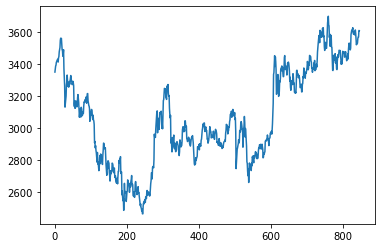

In [10]:
share_prices = ts.get_k_data('000001', start='2018-01-01', index=True)['close'].values
share_prices = share_prices.astype('float32')
plt.plot(share_prices)
plt.show()

In [18]:
DAYS_FOR_TRAIN = 5
EPOCHS = 500
scaler = MinMaxScaler(feature_range=(-1, 1))
share_prices = scaler.fit_transform(share_prices.reshape(-1, 1))
dataset_x, dataset_y = create_dataset(share_prices, DAYS_FOR_TRAIN)
train_size = int(len(dataset_x) * 0.7)
train_x = dataset_x[:train_size]
train_y = dataset_y[:train_size]
test_x = dataset_x[train_size:]
test_y = dataset_y[train_size:]
train_x = train_x.reshape(-1, 1, DAYS_FOR_TRAIN)
train_y = train_y.reshape(-1, 1, 1)
train_x = torch.from_numpy(train_x)
train_y = torch.from_numpy(train_y)

In [19]:
model = LSTM_Regression(DAYS_FOR_TRAIN, 8, output_size=1, num_layers=2)
loss_function = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2) 
for epoch in range(EPOCHS):
    out = model(train_x)
    loss = loss_function(out, train_y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if (epoch + 1) % 100 == 0:
        print('Epoch: {}, Loss:{:.5f}'.format(epoch + 1, loss.item()))

Epoch: 100, Loss:0.00522
Epoch: 200, Loss:0.00355
Epoch: 300, Loss:0.00326
Epoch: 400, Loss:0.00321
Epoch: 500, Loss:0.00318


In [20]:
model = model.eval()
dataset_x = dataset_x.reshape(-1, 1, DAYS_FOR_TRAIN)
dataset_x = torch.from_numpy(dataset_x)
pred_y = model(dataset_x)
pred_y = pred_y.view(-1).data.numpy()
actual_pred_y = scaler.inverse_transform(pred_y.reshape(-1, 1))
actual_pred_y = actual_pred_y.reshape(-1, 1).flatten()
test_y = scaler.inverse_transform(test_y.reshape(-1, 1))
test_y = test_y.reshape(-1, 1).flatten()
actual_pred_y = actual_pred_y[-len(test_y):]
test_y = test_y.reshape(-1, 1)
assert len(actual_pred_y) == len(test_y)

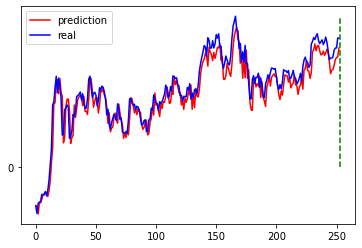

In [21]:
my_y_ticks = np.arange(0, 4000,500)
plt.yticks(my_y_ticks)
plt.plot(actual_pred_y, 'r', label='prediction')
plt.plot(test_y, 'b', label='real')
plt.plot((len(actual_pred_y), len(test_y)), (0, 1), 'g--')
plt.legend(loc='best')
plt.show()